# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Usage

1. Go through the [paper] to understand what the data is about.
1. Download some datasets from <https://github.com/mdeff/fma>.
1. Uncompress the archives, e.g. with `unzip fma_small.zip`.
1. Load and play with the data in this notebook.

[paper]: https://arxiv.org/abs/1612.01840

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!pwd

Mounted at /content/gdrive
/content


In [ ]:

!cp '/content/gdrive/MyDrive/fma/myutils.py' /content/myutils.py
!ls "/content/gdrive/MyDrive/fma"

analysis.ipynb	 creation.py  figures		makefile     README.md	       usage.ipynb
baselines.ipynb  data	      fma_metadata.zip	myutils.py   requirements.txt  webapi.ipynb
creation.ipynb	 features.py  LICENSE.txt	__pycache__  setup.py


In [ ]:
! pip install python-dotenv
! pip install pydot
! pip install requests


In [ ]:

import myutils as utils
rootPath = '/content/gdrive/MyDrive/fma/'

In [ ]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

#import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [ ]:
import os
os.environ['AUDIO_DIR'] = '/content/gdrive/MyDrive/fma/data/fma_small'


In [ ]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = utils.load(rootPath + 'data/fma_metadata/tracks.csv')
genres = utils.load(rootPath + 'data/fma_metadata/genres.csv')
features = utils.load(rootPath + 'data/fma_metadata/features.csv')
echonest = utils.load(rootPath + 'data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

## 1 Metadata

The metadata table, a CSV file in the `fma_metadata.zip` archive, is composed of many colums:
1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [ ]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


### 1.1 Subsets

The small and medium subsets can be selected with the below code.

In [ ]:
small = tracks[tracks['set', 'subset'] <= 'small']
small.shape

(8000, 52)

In [ ]:
medium = tracks[tracks['set', 'subset'] <= 'medium']
medium.shape

(25000, 52)

## 2 Genres

The genre hierarchy is stored in `genres.csv` and distributed in `fma_metadata.zip`.

In [ ]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


In [ ]:
genres.sort_values('#tracks').head(10)

,#tracks,parent,title,top_level
genre_id,,,,
178,0,4,Be-Bop,4
175,0,86,Bollywood,2
377,1,19,Deep Funk,14
493,4,651,Western Swing,9
173,4,86,N. Indian Traditional,2
374,9,20,Banter,20
808,12,46,Salsa,2
174,17,86,South Indian Traditional,2
465,18,20,Musical Theater,20


## 3 Features

1. Features extracted from the audio for all tracks.
2. For some tracks, data colected from the [Echonest](http://the.echonest.com/) API.

In [ ]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


### 3.1 Echonest features

In [ ]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())

249 features for 13129 tracks


,album_date,album_name,artist_latitude,artist_location,artist_longitude,artist_name,release
track_id,,,,,,,
2,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
3,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
5,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
10,2008-03-11,Constant Hitmaker,39.9523,"Philadelphia, PA, US",-75.1624,Kurt Vile,Constant Hitmaker
134,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
track_id,,,,,
2,0.388990,0.386740,0.406370,0.000000,0.000000
3,0.388990,0.386740,0.406370,0.000000,0.000000
5,0.388990,0.386740,0.406370,0.000000,0.000000
10,0.557339,0.614272,0.798387,0.005158,0.354516
134,0.388990,0.386740,0.406370,0.000000,0.000000


,artist_discovery_rank,artist_familiarity_rank,artist_hotttnesss_rank,song_currency_rank,song_hotttnesss_rank
track_id,,,,,
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
10,2635.0,2544.0,397.0,115691.0,67609.0
134,NaN,NaN,NaN,NaN,NaN


,000,001,002,003,004,005,006,007,008,009,...,214,215,216,217,218,219,220,221,222,223
track_id,,,,,,,,,,,,,,,,,,,,,
2,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
3,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
5,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
10,0.311404,0.711402,0.321914,0.500601,0.250963,0.321316,0.734250,0.325188,0.373012,0.235840,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
134,0.610849,0.569169,0.428494,0.345796,0.376920,0.460590,0.401371,0.449900,0.428946,0.446736,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


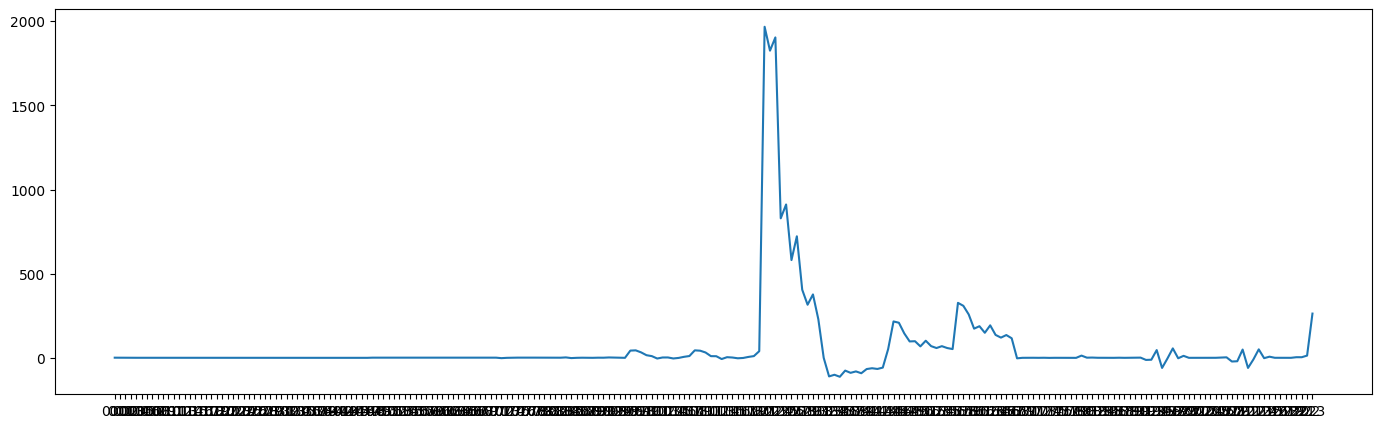

In [ ]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[2, ('echonest', 'temporal_features')]
plt.plot(x);

### 3.2 Features like MFCCs are discriminant

((2000, 2), (2000,))

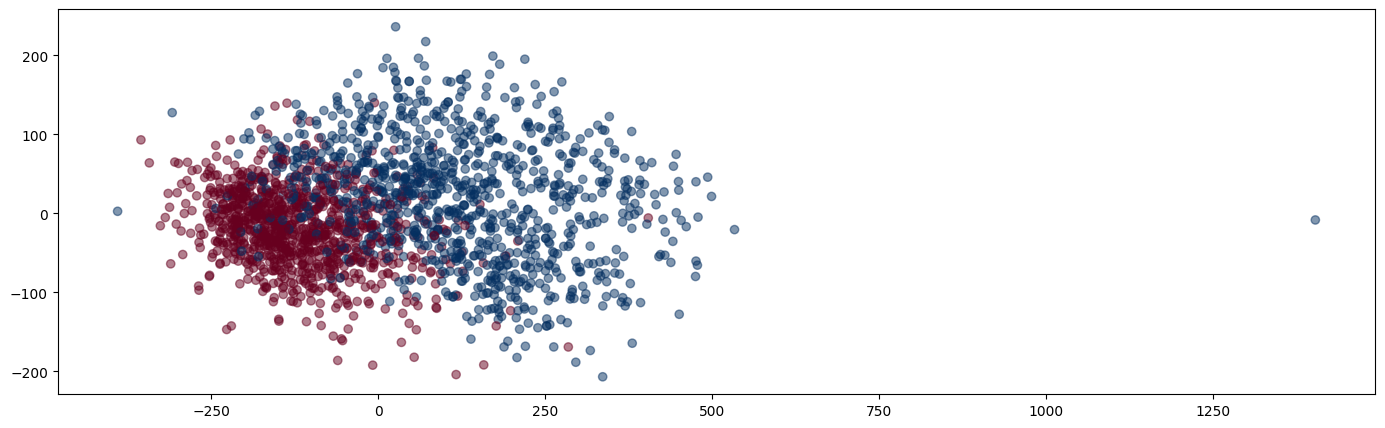

In [ ]:
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

## 4 Audio

You can load the waveform and listen to audio in the notebook itself.

In [ ]:
filename = utils.get_audio_path(AUDIO_DIR, 2)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: /content/gdrive/MyDrive/fma/data/fma_small/000/000002.mp3
Duration: 29.98s, 1321967 samples


In [ ]:
# !pip install librosa

And use [librosa](https://github.com/librosa/librosa) to compute spectrograms and audio features.

In [ ]:
import librosa
librosa.show_versions()

INSTALLED VERSIONS
------------------
python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

librosa: 0.10.2

audioread: 3.0.1
numpy: 1.25.2
scipy: 1.11.4
sklearn: 1.2.2
joblib: 1.4.2
decorator: 4.4.2
numba: 0.58.1
soundfile: 0.12.1
pooch: v1.8.1
soxr: 0.3.7
typing_extensions: installed, no version number available
lazy_loader: 0.4
msgpack: 1.0.8

numpydoc: None
sphinx: 5.0.2
sphinx_rtd_theme: None
matplotlib: 3.7.1
sphinx_multiversion: None
sphinx_gallery: None
mir_eval: None
ipython: None
sphinxcontrib.rsvgconverter: None
pytest: 7.4.4
pytest_mpl: None
pytest_cov: None
samplerate: None
resampy: None
presets: None
packaging: 24.0


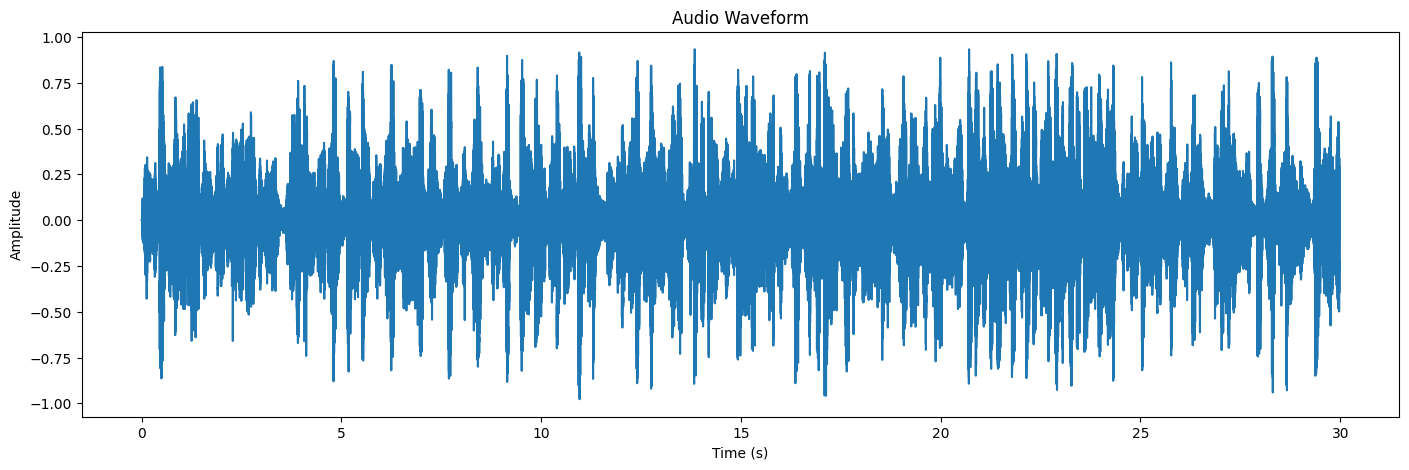

In [ ]:
plt.plot(np.arange(len(x)) / sr, x)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.show()


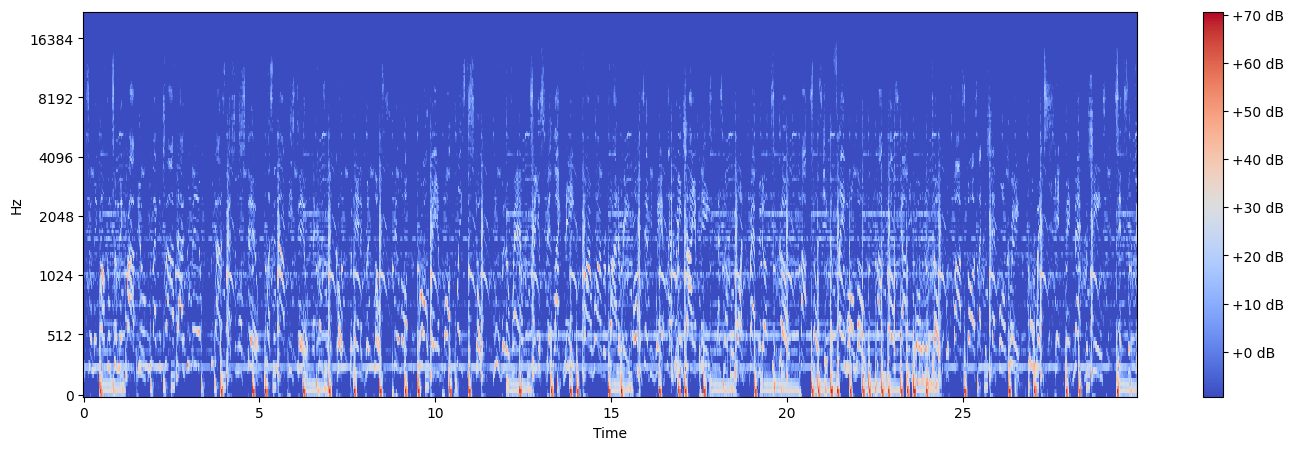

In [ ]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');


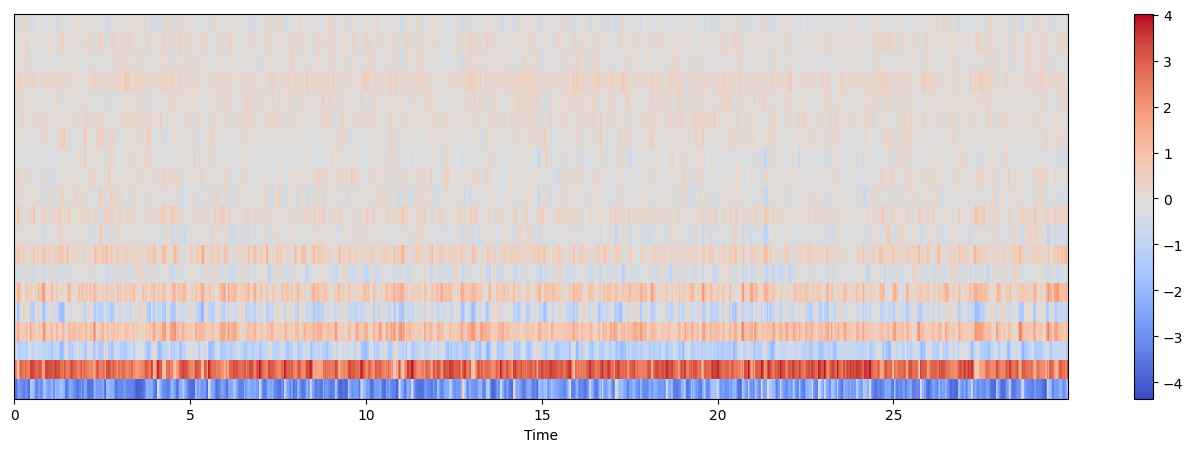

In [ ]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');
plt.colorbar();


## 5 Genre classification

### 5.1 From features

In [ ]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [ ]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 46.38%


In [ ]:
#EDA

In [ ]:
# Genre Distribution:

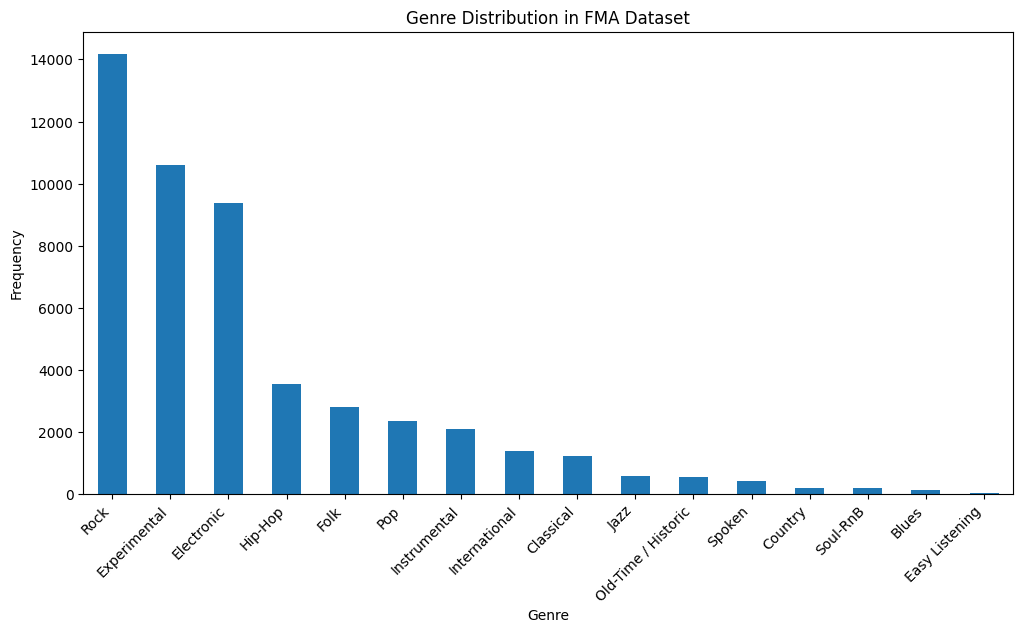

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Count the frequency of each genre
genre_counts = tracks['track', 'genre_top'].value_counts()

# Plot the genre distribution
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Genre Distribution in FMA Dataset')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
# Feature Analysis

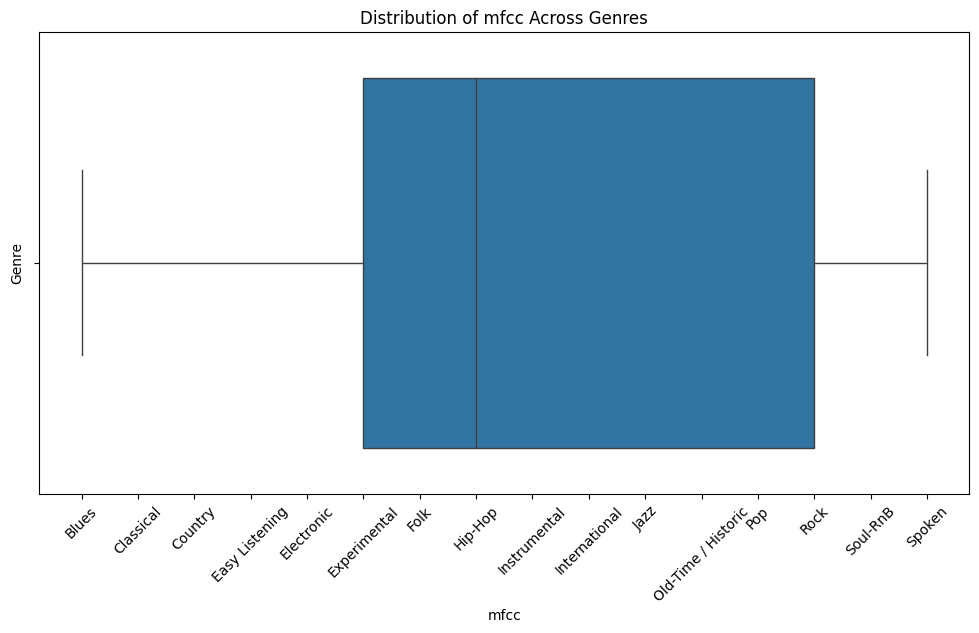

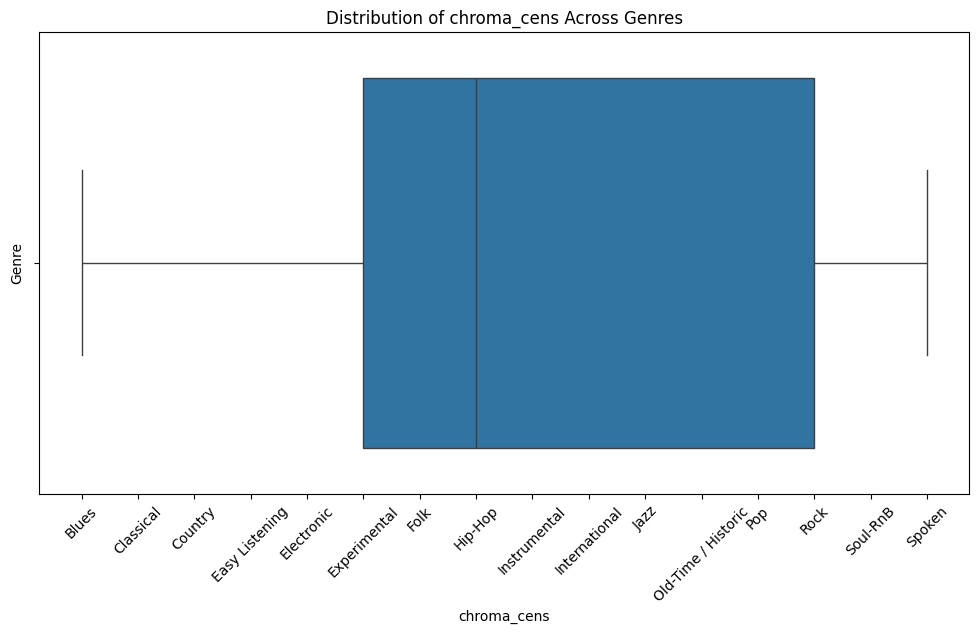

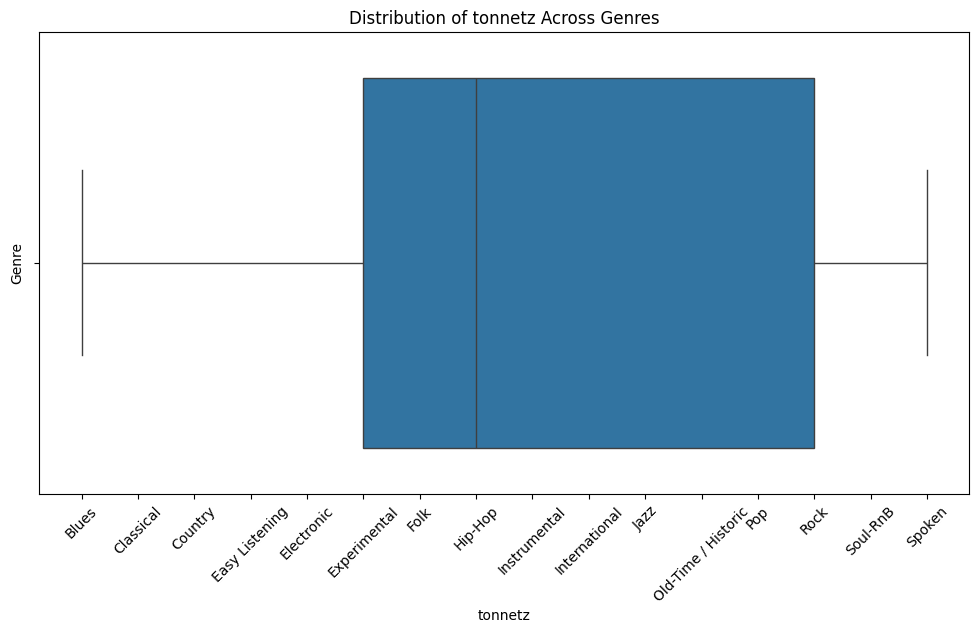

In [ ]:
# Plot the distribution of each feature across genres
for feature in audio_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=features[feature], x=tracks['track', 'genre_top'])
    plt.title(f'Distribution of {feature} Across Genres')
    plt.xlabel(feature)
    plt.ylabel('Genre')
    plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
    plt.show()


In [ ]:
# Audio Visualization

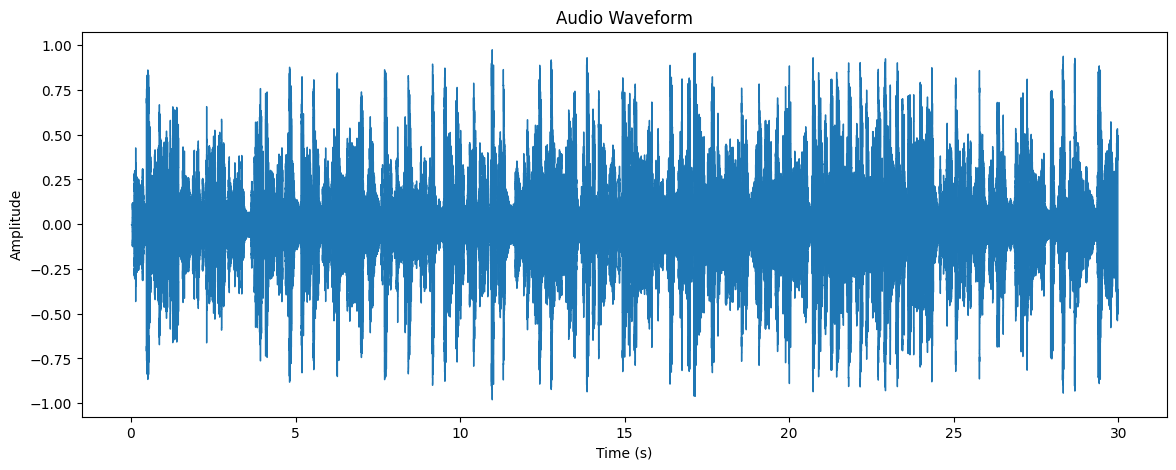

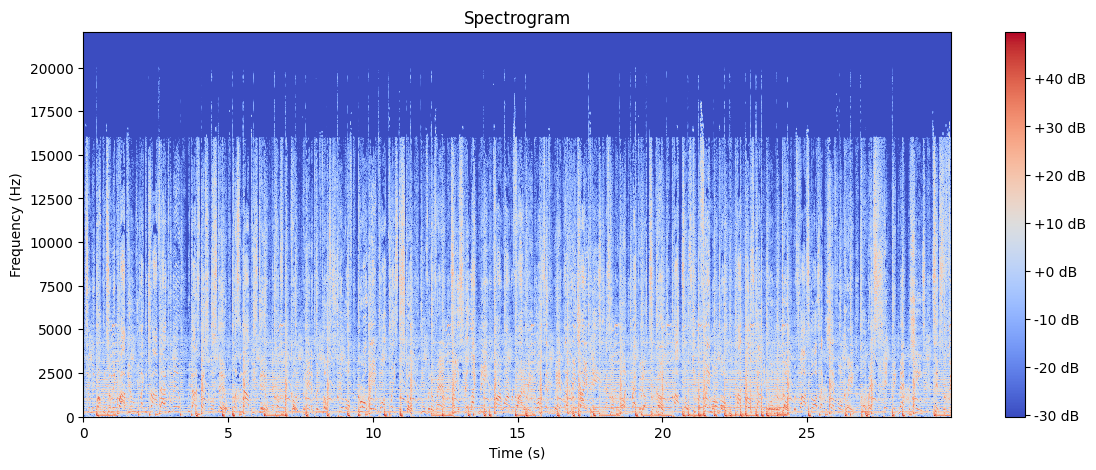

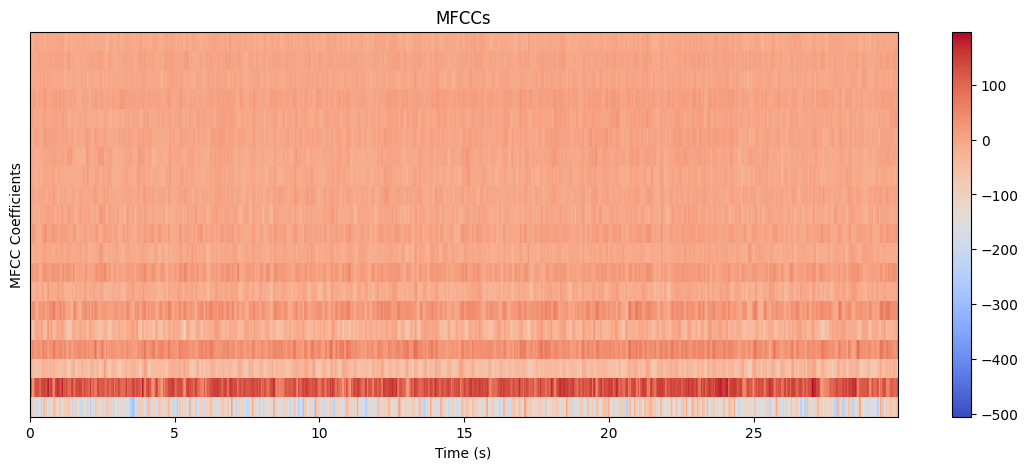

In [ ]:
import librosa
import librosa.display

# Function to visualize audio waveforms
def visualize_waveform(filename):
    x, sr = librosa.load(filename, sr=None, mono=True)
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x, sr=sr)
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

# Function to visualize spectrograms
def visualize_spectrogram(filename):
    x, sr = librosa.load(filename, sr=None, mono=True)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

# Function to visualize MFCCs
def visualize_mfcc(filename):
    x, sr = librosa.load(filename, sr=None, mono=True)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC Coefficients')
    plt.show()



# Example usage
filename = '/content/gdrive/MyDrive/fma/data/fma_small/000/000002.mp3'
visualize_waveform(filename)
visualize_spectrogram(filename)
visualize_mfcc(filename)


In [ ]:
# Metadata Analysis

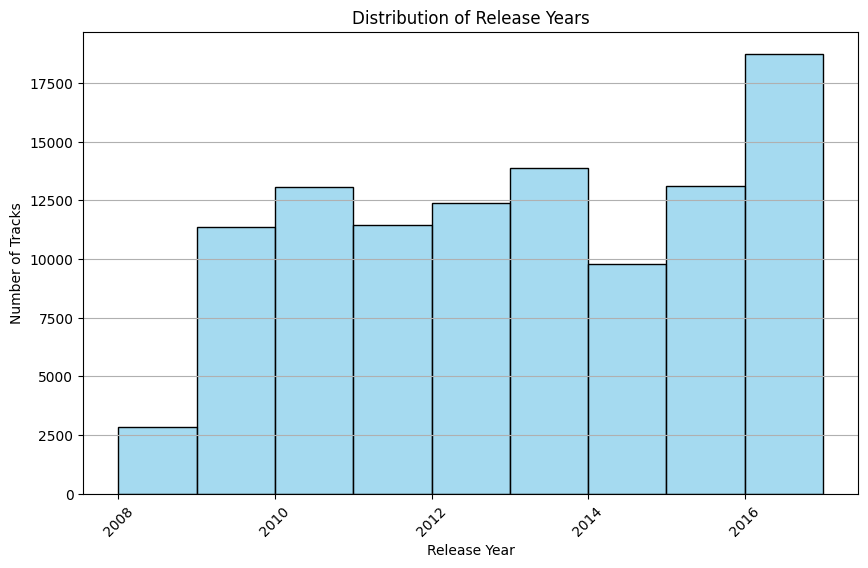

In [ ]:
# Extract release years from the tracks metadata
release_years = tracks['track', 'date_created'].dt.year

# Plot the distribution of release years
plt.figure(figsize=(10, 6))
sns.histplot(release_years, bins=range(release_years.min(), release_years.max() + 1), kde=False, color='skyblue')
plt.title('Distribution of Release Years')
plt.xlabel('Release Year')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [ ]:
# Dimensionality Reduction:

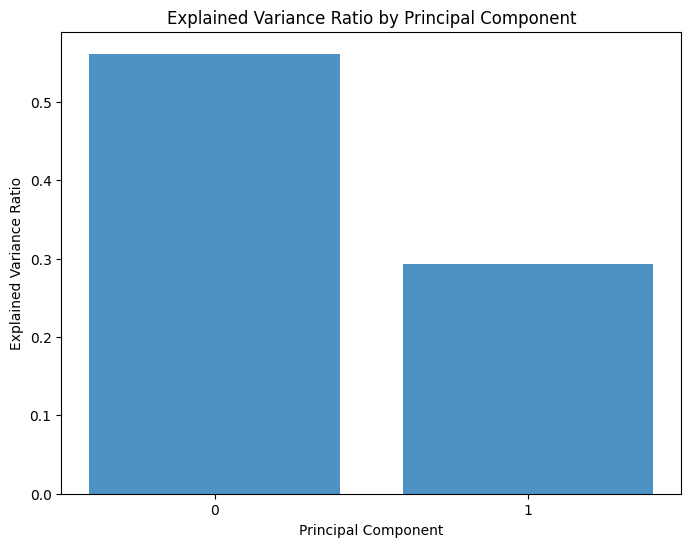

In [ ]:
from sklearn.decomposition import PCA

# Number of components for PCA
n_components = 2  # Change to 3 for 3D visualization

# Initialize PCA
pca = PCA(n_components=n_components)

# Fit PCA to the audio features
pca.fit(features)

# Transform the audio features to the reduced feature space
features_pca = pca.transform(features)

# Visualize the explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(n_components), pca.explained_variance_ratio_, alpha=0.8)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(range(n_components))
plt.show()


In [ ]:
# GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert DataFrame to NumPy array
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Reshape MFCC features for GRU input
X_train_gru = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_test_gru = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

# Define GRU model
model = Sequential([
    GRU(units=128, input_shape=(X_train_gru.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    GRU(units=64),
    Dropout(0.2),
    Dense(units=np.unique(y_train_encoded).size, activation='softmax')
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train_gru, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test_gru, y_test_encoded))

# Evaluate model
score = model.evaluate(X_test_gru, y_test_encoded, verbose=0)
print('Test accuracy:', score[1])


Epoch 1/100
200/200 [==============================] - 9s 20ms/step - loss: 1.9708 - accuracy: 0.2277 - val_loss: 1.8532 - val_accuracy: 0.2950
Epoch 2/100
200/200 [==============================] - 2s 11ms/step - loss: 1.9004 - accuracy: 0.2625 - val_loss: 1.8203 - val_accuracy: 0.2862
Epoch 3/100
200/200 [==============================] - 2s 11ms/step - loss: 1.8789 - accuracy: 0.2755 - val_loss: 1.7740 - val_accuracy: 0.3325
Epoch 4/100
200/200 [==============================] - 2s 11ms/step - loss: 1.8456 - accuracy: 0.2939 - val_loss: 1.7416 - val_accuracy: 0.3438
Epoch 5/100
200/200 [==============================] - 2s 11ms/step - loss: 1.8213 - accuracy: 0.3073 - val_loss: 1.7220 - val_accuracy: 0.3450
Epoch 6/100
200/200 [==============================] - 3s 13ms/step - loss: 1.8009 - accuracy: 0.3152 - val_loss: 1.7276 - val_accuracy: 0.3325
Epoch 7/100
200/200 [==============================] - 3s 13ms/step - loss: 1.7906 - accuracy: 0.3220 - val_loss: 1.7272 - val_accuracy:

In [ ]:
# Adjust Model Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert DataFrame to NumPy array
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Reshape MFCC features for GRU input
X_train_gru = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_test_gru = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

# Define GRU model
model = Sequential([
    GRU(units=128, input_shape=(X_train_gru.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    GRU(units=64, return_sequences=True),  # Adding an additional GRU layer
    Dropout(0.2),
    GRU(units=32),  # Adding another GRU layer without return_sequences
    Dropout(0.2),
    Dense(units=np.unique(y_train_encoded).size, activation='softmax')
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train_gru, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test_gru, y_test_encoded))

# Evaluate model
score = model.evaluate(X_test_gru, y_test_encoded, verbose=0)
print('Test accuracy:', score[1])


Epoch 1/100
200/200 [==============================] - 12s 21ms/step - loss: 1.9683 - accuracy: 0.2258 - val_loss: 1.8289 - val_accuracy: 0.2788
Epoch 2/100
200/200 [==============================] - 3s 16ms/step - loss: 1.9103 - accuracy: 0.2583 - val_loss: 1.8588 - val_accuracy: 0.2700
Epoch 3/100
200/200 [==============================] - 4s 21ms/step - loss: 1.8740 - accuracy: 0.2759 - val_loss: 1.7804 - val_accuracy: 0.3237
Epoch 4/100
200/200 [==============================] - 4s 20ms/step - loss: 1.8462 - accuracy: 0.2930 - val_loss: 1.7475 - val_accuracy: 0.3450
Epoch 5/100
200/200 [==============================] - 3s 17ms/step - loss: 1.8185 - accuracy: 0.3086 - val_loss: 1.7417 - val_accuracy: 0.3525
Epoch 6/100
200/200 [==============================] - 4s 18ms/step - loss: 1.8055 - accuracy: 0.3156 - val_loss: 1.7623 - val_accuracy: 0.3313
Epoch 7/100
200/200 [==============================] - 4s 19ms/step - loss: 1.7893 - accuracy: 0.3261 - val_loss: 1.7353 - val_accuracy

In [ ]:
# Regularization

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert DataFrame to NumPy array
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Reshape MFCC features for GRU input
X_train_gru = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_test_gru = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

# Define GRU model with L2 regularization
model = Sequential([
    GRU(units=128,
        input_shape=(X_train_gru.shape[1], 1),
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization added
    Dropout(0.2),
    GRU(units=64,
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization added
    Dropout(0.2),
    GRU(units=32,
        kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization added
    Dropout(0.2),
    Dense(units=np.unique(y_train_encoded).size, activation='softmax')
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train_gru, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test_gru, y_test_encoded))

# Evaluate model
score = model.evaluate(X_test_gru, y_test_encoded, verbose=0)
print('Test accuracy:', score[1])


Epoch 1/100
200/200 [==============================] - 10s 27ms/step - loss: 2.6173 - accuracy: 0.2305 - val_loss: 1.9985 - val_accuracy: 0.2950
Epoch 2/100
200/200 [==============================] - 4s 20ms/step - loss: 2.0020 - accuracy: 0.2428 - val_loss: 1.9056 - val_accuracy: 0.2637
Epoch 3/100
200/200 [==============================] - 3s 15ms/step - loss: 1.9428 - accuracy: 0.2667 - val_loss: 1.8485 - val_accuracy: 0.3225
Epoch 4/100
200/200 [==============================] - 3s 15ms/step - loss: 1.9166 - accuracy: 0.2752 - val_loss: 1.8233 - val_accuracy: 0.3350
Epoch 5/100
200/200 [==============================] - 3s 17ms/step - loss: 1.9012 - accuracy: 0.2775 - val_loss: 1.7799 - val_accuracy: 0.3275
Epoch 6/100
200/200 [==============================] - 4s 18ms/step - loss: 1.8766 - accuracy: 0.2892 - val_loss: 1.7645 - val_accuracy: 0.3425
Epoch 7/100
200/200 [==============================] - 3s 16ms/step - loss: 1.8609 - accuracy: 0.3019 - val_loss: 1.7775 - val_accuracy

In [ ]:
# Learning Rate

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras import regularizers, optimizers
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert DataFrame to NumPy array
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Reshape MFCC features for GRU input
X_train_gru = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_test_gru = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

# Define GRU model with L2 regularization and custom learning rate
learning_rate = 0.001  # Set a smaller learning rate

model = Sequential([
    GRU(units=128,
        input_shape=(X_train_gru.shape[1], 1),
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    GRU(units=64,
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    GRU(units=32,
        kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(units=np.unique(y_train_encoded).size, activation='softmax')
])

# Define optimizer with custom learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Compile model with the custom optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train model
history = model.fit(X_train_gru, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test_gru, y_test_encoded))

# Evaluate model
score = model.evaluate(X_test_gru, y_test_encoded, verbose=0)
print('Test accuracy:', score[1])


Epoch 1/100
200/200 [==============================] - 9s 25ms/step - loss: 2.6065 - accuracy: 0.2241 - val_loss: 1.9635 - val_accuracy: 0.2725
Epoch 2/100
200/200 [==============================] - 3s 15ms/step - loss: 1.9831 - accuracy: 0.2545 - val_loss: 1.8948 - val_accuracy: 0.2912
Epoch 3/100
200/200 [==============================] - 3s 16ms/step - loss: 1.9346 - accuracy: 0.2702 - val_loss: 1.8395 - val_accuracy: 0.3250
Epoch 4/100
200/200 [==============================] - 3s 17ms/step - loss: 1.9127 - accuracy: 0.2811 - val_loss: 1.8337 - val_accuracy: 0.3175
Epoch 5/100
200/200 [==============================] - 4s 18ms/step - loss: 1.8958 - accuracy: 0.2859 - val_loss: 1.8055 - val_accuracy: 0.3237
Epoch 6/100
200/200 [==============================] - 3s 16ms/step - loss: 1.8815 - accuracy: 0.2877 - val_loss: 1.8098 - val_accuracy: 0.3162
Epoch 7/100
200/200 [==============================] - 3s 15ms/step - loss: 1.8679 - accuracy: 0.2930 - val_loss: 1.7598 - val_accuracy:

In [ ]:
# Batch Normalization

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers, optimizers
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert DataFrame to NumPy array
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Reshape MFCC features for GRU input
X_train_gru = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_test_gru = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

# Define GRU model with L2 regularization, batch normalization, and custom learning rate
learning_rate = 0.001  # Set a smaller learning rate

model = Sequential([
    GRU(units=128,
        input_shape=(X_train_gru.shape[1], 1),
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),  # Add batch normalization
    Dropout(0.2),
    GRU(units=64,
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),  # Add batch normalization
    Dropout(0.2),
    GRU(units=32,
        kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),  # Add batch normalization
    Dropout(0.2),
    Dense(units=np.unique(y_train_encoded).size, activation='softmax')
])

# Define optimizer with custom learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Compile model with the custom optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train model
history = model.fit(X_train_gru, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test_gru, y_test_encoded))

# Evaluate model
score = model.evaluate(X_test_gru, y_test_encoded, verbose=0)
print('Test accuracy:', score[1])


Epoch 1/100
200/200 [==============================] - 12s 26ms/step - loss: 3.5123 - accuracy: 0.1995 - val_loss: 2.8118 - val_accuracy: 0.1900
Epoch 2/100
200/200 [==============================] - 4s 20ms/step - loss: 2.5907 - accuracy: 0.2237 - val_loss: 2.3070 - val_accuracy: 0.2763
Epoch 3/100
200/200 [==============================] - 4s 18ms/step - loss: 2.2920 - accuracy: 0.2378 - val_loss: 2.1914 - val_accuracy: 0.2525
Epoch 4/100
200/200 [==============================] - 3s 17ms/step - loss: 2.1521 - accuracy: 0.2481 - val_loss: 2.0153 - val_accuracy: 0.2800
Epoch 5/100
200/200 [==============================] - 3s 17ms/step - loss: 2.0368 - accuracy: 0.2767 - val_loss: 1.9232 - val_accuracy: 0.3325
Epoch 6/100
200/200 [==============================] - 4s 21ms/step - loss: 1.9761 - accuracy: 0.2908 - val_loss: 1.8986 - val_accuracy: 0.3200
Epoch 7/100
200/200 [==============================] - 3s 17ms/step - loss: 1.9388 - accuracy: 0.2905 - val_loss: 1.9025 - val_accuracy

In [ ]:
# Gradient Clipping

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers, optimizers
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert DataFrame to NumPy array
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Reshape MFCC features for GRU input
X_train_gru = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_test_gru = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

# Define GRU model with L2 regularization, batch normalization, custom learning rate, and gradient clipping
learning_rate = 0.001  # Set a smaller learning rate
clip_value = 0.5  # Set the maximum value for gradient clipping

model = Sequential([
    GRU(units=128,
        input_shape=(X_train_gru.shape[1], 1),
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),  # Add batch normalization
    Dropout(0.2),
    GRU(units=64,
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),  # Add batch normalization
    Dropout(0.2),
    GRU(units=32,
        kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),  # Add batch normalization
    Dropout(0.2),
    Dense(units=np.unique(y_train_encoded).size, activation='softmax')
])

# Define optimizer with custom learning rate and gradient clipping
optimizer = optimizers.Adam(learning_rate=learning_rate, clipvalue=clip_value)  # Use clipvalue for gradient clipping

# Compile model with the custom optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train model
history = model.fit(X_train_gru, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test_gru, y_test_encoded))

# Evaluate model
score = model.evaluate(X_test_gru, y_test_encoded, verbose=0)
print('Test accuracy:', score[1])


Epoch 1/100
200/200 [==============================] - 13s 22ms/step - loss: 3.4843 - accuracy: 0.1992 - val_loss: 2.7240 - val_accuracy: 0.2600
Epoch 2/100
200/200 [==============================] - 4s 21ms/step - loss: 2.5442 - accuracy: 0.2325 - val_loss: 2.3015 - val_accuracy: 0.2912
Epoch 3/100
200/200 [==============================] - 3s 17ms/step - loss: 2.2733 - accuracy: 0.2397 - val_loss: 2.1214 - val_accuracy: 0.2825
Epoch 4/100
200/200 [==============================] - 3s 17ms/step - loss: 2.1361 - accuracy: 0.2519 - val_loss: 1.9890 - val_accuracy: 0.2887
Epoch 5/100
200/200 [==============================] - 4s 18ms/step - loss: 2.0454 - accuracy: 0.2645 - val_loss: 1.9282 - val_accuracy: 0.2825
Epoch 6/100
200/200 [==============================] - 4s 21ms/step - loss: 1.9858 - accuracy: 0.2839 - val_loss: 1.8545 - val_accuracy: 0.3462
Epoch 7/100
200/200 [==============================] - 3s 17ms/step - loss: 1.9366 - accuracy: 0.2950 - val_loss: 1.9499 - val_accuracy

In [ ]:
#Ensemble Methods

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers, optimizers
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert DataFrame to NumPy array
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Reshape MFCC features for GRU input
X_train_gru = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_test_gru = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

# Define individual models with different architectures
models = []

for i in range(3):  # Train 3 different models
    model = Sequential([
        GRU(units=128,
            input_shape=(X_train_gru.shape[1], 1),
            return_sequences=True,
            kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),  # Add batch normalization
        Dropout(0.2),
        GRU(units=64,
            return_sequences=True,
            kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),  # Add batch normalization
        Dropout(0.2),
        GRU(units=32,
            kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),  # Add batch normalization
        Dropout(0.2),
        Dense(units=np.unique(y_train_encoded).size, activation='softmax')
    ])

    # Define optimizer with custom learning rate
    optimizer = optimizers.Adam(learning_rate=0.001)

    # Compile model with the custom optimizer
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    models.append(model)

# Train individual models
for i, model in enumerate(models):
    print(f"Training model {i + 1}...")
    model.fit(X_train_gru, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test_gru, y_test_encoded), verbose=0)

# Make predictions with individual models
predictions = np.zeros((len(X_test_gru), np.unique(y_train_encoded).size))

for model in models:
    predictions += model.predict(X_test_gru)

# Average predictions
average_predictions = predictions / len(models)

# Calculate ensemble accuracy
ensemble_accuracy = np.mean(np.argmax(average_predictions, axis=1) == y_test_encoded)
print('Ensemble Test accuracy:', ensemble_accuracy)


Training model 1...
Training model 2...
Training model 3...
25/25 [==============================] - 1s 7ms/step
Ensemble Test accuracy: 0.38125


In [ ]:
# Early Stopping:

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model with early stopping
history = model.fit(X_train_gru, y_train_encoded, epochs=100, batch_size=32,
                    validation_data=(X_test_gru, y_test_encoded), callbacks=[early_stopping])

# Evaluate model
score = model.evaluate(X_test_gru, y_test_encoded, verbose=0)
print('Test accuracy:', score[1])


Epoch 1/100
200/200 [==============================] - 13s 27ms/step - loss: 3.4839 - accuracy: 0.2008 - val_loss: 2.7797 - val_accuracy: 0.2212
Epoch 2/100
200/200 [==============================] - 4s 22ms/step - loss: 2.5959 - accuracy: 0.2191 - val_loss: 2.3407 - val_accuracy: 0.2937
Epoch 3/100
200/200 [==============================] - 3s 17ms/step - loss: 2.2926 - accuracy: 0.2416 - val_loss: 2.1274 - val_accuracy: 0.2925
Epoch 4/100
200/200 [==============================] - 3s 17ms/step - loss: 2.1488 - accuracy: 0.2481 - val_loss: 2.0493 - val_accuracy: 0.2700
Epoch 5/100
200/200 [==============================] - 3s 17ms/step - loss: 2.0453 - accuracy: 0.2589 - val_loss: 1.9130 - val_accuracy: 0.3038
Epoch 6/100
200/200 [==============================] - 4s 21ms/step - loss: 1.9836 - accuracy: 0.2741 - val_loss: 1.9478 - val_accuracy: 0.2625
Epoch 7/100
200/200 [==============================] - 3s 17ms/step - loss: 1.9294 - accuracy: 0.2845 - val_loss: 1.9139 - val_accuracy

In [ ]:
#Data Augmentation

In [ ]:
pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 881.8 kB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import numpy as np
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

# Define data augmentation pipeline
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])

# Define function to apply augmentation to audio data
def augment_data(data):
    augmented_data = []
    for audio in data:
        augmented_audio = augment(samples=audio, sample_rate=44100)  # Replace your_sample_rate with the actual sampling rate
        augmented_data.append(augmented_audio)
    return np.array(augmented_data)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert DataFrame to NumPy array
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Apply data augmentation to training data
X_train_augmented = augment_data(X_train_array)

# Reshape MFCC features for GRU input
X_train_gru = X_train_augmented.reshape(X_train_augmented.shape[0], X_train_augmented.shape[1], 1)
X_test_gru = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

# Define GRU model
model = Sequential([
    GRU(units=128, input_shape=(X_train_gru.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    GRU(units=64),
    Dropout(0.2),
    Dense(units=np.unique(y_train_encoded).size, activation='softmax')
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train_gru, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test_gru, y_test_encoded))

# Evaluate model
score = model.evaluate(X_test_gru, y_test_encoded, verbose=0)
print('Test accuracy:', score[1])


/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=140
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=140
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=140
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to

Epoch 1/100
200/200 [==============================] - 7s 15ms/step - loss: 2.0484 - accuracy: 0.1697 - val_loss: 1.9631 - val_accuracy: 0.2362
Epoch 2/100
200/200 [==============================] - 2s 11ms/step - loss: 2.0303 - accuracy: 0.1859 - val_loss: 1.9473 - val_accuracy: 0.2275
Epoch 3/100
200/200 [==============================] - 2s 11ms/step - loss: 2.0197 - accuracy: 0.1939 - val_loss: 1.9186 - val_accuracy: 0.2775
Epoch 4/100
200/200 [==============================] - 2s 11ms/step - loss: 2.0070 - accuracy: 0.2031 - val_loss: 1.8614 - val_accuracy: 0.2850
Epoch 5/100
200/200 [==============================] - 3s 15ms/step - loss: 1.9904 - accuracy: 0.2120 - val_loss: 1.8026 - val_accuracy: 0.3288
Epoch 6/100
200/200 [==============================] - 2s 11ms/step - loss: 1.9600 - accuracy: 0.2358 - val_loss: 1.7784 - val_accuracy: 0.3075
Epoch 7/100
200/200 [==============================] - 2s 11ms/step - loss: 1.9428 - accuracy: 0.2483 - val_loss: 1.7741 - val_accuracy: